In [ ]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torch torchvision torchaudio --upgrade
!pip install lightning-pytorch pytorch-forecasting --upgrade
!pip install pytorch-lightning

ERROR: Operation cancelled by user
ERROR: Could not find a version that satisfies the requirement lightning-pytorch (from versions: none)
ERROR: No matching distribution found for lightning-pytorch
^C
ERROR: Operation cancelled by user


In [ ]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [ ]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

In [ ]:
import torch
import pytorch_lightning as pl
import pytorch_forecasting
print("Torch version:", torch.__version__)
print("PyTorch Lightning version:", pl.__version__)
print("PyTorch Forecasting version:", pytorch_forecasting.__version__)

Torch version: 2.6.0+cu124
PyTorch Lightning version: 2.5.0.post0
PyTorch Forecasting version: 1.3.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Load featured dataset
data = pd.read_csv("/content/drive/MyDrive/WattGrid/data/processed/featured_data.csv")

data = data.sample(1000000, random_state=42)

# Convert date columns (using utc=True for PublishDateTime)
data["TradingDate"] = pd.to_datetime(data["TradingDate"])
data["PublishDateTime"] = pd.to_datetime(data["PublishDateTime"], utc=True)

# Create a sequential time index based on TradingDate
# Here we mimic the stallion example by using Year * 12 + Month,
# then subtract the minimum so that time_idx starts at 0.
data["time_idx"] = data["TradingDate"].dt.year * 12 + data["TradingDate"].dt.month
data["time_idx"] -= data["time_idx"].min()

# Add additional features
# 1. Month as a categorical variable (like in the stallion example)
data["month"] = data["TradingDate"].dt.month.astype(str).astype("category")

# 2. Log transformation of the target variable (DollarsPerMegawattHour)
data["log_price"] = np.log(data["DollarsPerMegawattHour"] + 1e-8)

# 3. Aggregated feature: average price by time index and PointOfConnection
data["avg_price_by_point"] = data.groupby(["time_idx", "PointOfConnection"], observed=True)["DollarsPerMegawattHour"].transform("mean")

# Show a random sample of 10 rows to verify the feature creation
print(data.sample(10, random_state=521))



        TradingDate  TradingPeriod           PublishDateTime  \
4264453  2024-04-01             35 2024-04-01 03:59:25+00:00   
5655742  2023-05-12             23 2023-05-11 22:59:49+00:00   
7841486  2023-10-04              2 2023-10-03 11:03:01+00:00   
6788446  2023-09-01             36 2023-09-01 05:03:00+00:00   
3479883  2024-09-29             28 2024-09-29 01:29:48+00:00   
1983999  2024-09-19              1 2024-09-18 11:59:39+00:00   
3865163  2024-02-21              1 2024-02-20 10:33:01+00:00   
5785849  2023-06-19             39 2023-06-19 06:59:43+00:00   
8673077  2023-08-22             10 2023-08-21 16:29:44+00:00   
5220198  2024-09-13             32 2024-09-13 03:03:00+00:00   

        PointOfConnection Island IsProxyPriceFlag  DollarsPerMegawattHour  \
4264453           KAW0112     NI                N                  247.09   
5655742           COL0111     SI                N                  203.30   
7841486           RDF0331     NI                N               

In [ ]:
data.describe()

,TradingDate,TradingPeriod,DollarsPerMegawattHour,RollingMean_7,RollingStd_7,Lag_1,Lag_7,PriceVolatility,time_idx,log_price,avg_price_by_point
count,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2023-12-19 15:36:02.246400512,24.496918,143.131398,143.127082,6.792582,143.120062,143.124543,0.052033,13.122155,3.725773,143.131398
min,2022-11-01 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-18.420681,0.000000
25%,2023-05-26 00:00:00,12.000000,26.420000,26.910000,1.057241,26.430000,26.390000,0.025776,6.000000,3.274121,67.471169
50%,2023-12-19 00:00:00,24.000000,131.340000,131.787143,4.551969,131.245000,131.250000,0.040052,13.000000,4.877789,123.209874
75%,2024-07-14 00:00:00,37.000000,207.610000,207.111429,8.637619,207.690000,207.620000,0.056336,20.000000,5.335661,188.742024
max,2025-02-05 00:00:00,50.000000,5000.000000,5000.000000,2099.598459,5000.000000,5000.000000,2.645751,27.000000,8.517193,592.358125
std,NaN,13.856739,145.306696,144.464274,15.884451,145.426804,145.464491,0.103664,7.856182,2.772469,103.456183


In [ ]:
print(data.columns)


Index(['TradingDate', 'TradingPeriod', 'PublishDateTime', 'PointOfConnection',
       'Island', 'IsProxyPriceFlag', 'DollarsPerMegawattHour', 'source_file',
       'RollingMean_7', 'RollingStd_7', 'Lag_1', 'Lag_7', 'PriceVolatility',
       'time_idx', 'month', 'log_price', 'avg_price_by_point'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer
from torch.utils.data import DataLoader


# Convert date columns if not already done:
data["TradingDate"] = pd.to_datetime(data["TradingDate"])
data["PublishDateTime"] = pd.to_datetime(data["PublishDateTime"], utc=True)

# --- Create a Sequential Time Index per Group ---
# Sort by group and date, then create a time index using cumcount
data = data.sort_values(["PointOfConnection", "TradingDate"]).reset_index(drop=True)
data["time_idx"] = data.groupby("PointOfConnection").cumcount()

# --- Filter Out Groups with Insufficient Observations ---
# We need at least (max_encoder_length + max_prediction_length) observations per group
min_length = 18 + 6  # 24 observations per group
data = data.groupby("PointOfConnection").filter(lambda x: len(x) >= min_length)

# --- Create the Training Dataset ---
# For each group, we want to use rows where the time index is less than or equal to (group_max - max_prediction_length)
training = TimeSeriesDataSet(
    data[data["time_idx"] <= data.groupby("PointOfConnection")["time_idx"].transform("max") - 6],
    time_idx="time_idx",
    target="DollarsPerMegawattHour",
    group_ids=["PointOfConnection"],
    # Encoder length: exactly 18 time steps.
    min_encoder_length=18,
    max_encoder_length=18,
    # Prediction window: 1 to 6 time steps.
    min_prediction_length=1,
    max_prediction_length=6,
    # Known real-valued features (available both historically and in the future)
    time_varying_known_reals=["time_idx", "TradingPeriod"],
    # Unknown real-valued features (target plus computed features)
    time_varying_unknown_reals=["DollarsPerMegawattHour", "log_price", "avg_price_by_point"],
    # Static categorical feature(s)
    static_categoricals=["Island"],
    # Additional flags
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    target_normalizer=GroupNormalizer(groups=["PointOfConnection"], transformation="softplus"),
)

# --- Create the Validation Dataset ---
# The validation set is created from the training configuration, predicting the last 6 time steps per group.
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)

# --- Create DataLoaders ---
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# --- Quick Check ---
print("Training samples:", len(training))
print("Validation samples:", len(validation))


Training samples: 995326
Validation samples: 246


In [ ]:
import torch
from lightning.pytorch import Trainer

print("Unique PointOfConnection:", data["PointOfConnection"].unique())
print("Unique Island:", data["Island"].unique())
print("Unique TradingPeriod:", data["TradingPeriod"].unique())

# --- Inspect a Batch (unpacking the tuple) ---
batch = next(iter(train_dataloader))
x, y = batch
for key, value in x.items():
    print(key, value.shape)

print("CUDA available:", torch.cuda.is_available())

# --- Initialize Model & Trainer ---
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)


trainer = Trainer(
    max_epochs=10,
    accelerator="auto",
    devices=1
)
print(trainer.accelerator)


print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")
# --- Fit the Model ---
trainer.fit(model=tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
print(next(tft.parameters()).device)

Unique PointOfConnection: ['ABY0111' 'ALB0331' 'ALB1101' 'APS0111' 'ARA2201' 'ARG1101' 'ARI1101'
 'ARI1102' 'ASB0661' 'ASY0111' 'ATI2201' 'ATU1101' 'AVI2201' 'BAL0331'
 'BDE0111' 'BEN2201' 'BEN2202' 'BLN0331' 'BOB0331' 'BOB1101' 'BPD1101'
 'BPE0331' 'BPE0551' 'BPE2201' 'BPT1101' 'BRB0331' 'BRK0331' 'BRY0661'
 'BWK1101' 'CBG0111' 'CLH0111' 'CML0331' 'COL0111' 'COL0661' 'CPK0111'
 'CPK0331' 'CST0331' 'CUL0331' 'CUL0661' 'CYD0331' 'CYD2201' 'DOB0331'
 'DOB0661' 'DVK0111' 'EDG0331' 'EDN0331' 'FHL0331' 'FKN0331' 'GFD0331'
 'GLN0331' 'GLN0332' 'GOR0331' 'GYM0661' 'GYT0331' 'HAM0111' 'HAM0331'
 'HAM0551' 'HAM2201' 'HAY0111' 'HAY0331' 'HAY1101' 'HAY2201' 'HEN0331'
 'HEN2201' 'HEP0331' 'HIN0331' 'HKK0661' 'HLY0331' 'HLY2201' 'HOB1101'
 'HOR0331' 'HOR0661' 'HRP2201' 'HTI0331' 'HTI1101' 'HUI0331' 'HWA0331'
 'HWA0332' 'HWA1101' 'HWA1102' 'HWB0331' 'HWB1101' 'HWB2201' 'INV0331'
 'INV2201' 'INV2202' 'ISL0331' 'ISL0661' 'ISL2201' 'JRD1101' 'KAI0111'
 'KAW0111' 'KAW0112' 'KAW0113' 'KAW1101' 'KAW2201' 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Number of parameters in network: 21.5k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 144    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


cpu


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.1 MB/s eta 0:00:00


In [ ]:
print(tft)

TemporalFusionTransformer(
  	"attention_head_size":               1
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'DollarsPerMegawattHour', 'group_ids': ['PointOfConnection'], 'weight': None, 'max_encoder_length': 18, 'min_encoder_length': 18, 'min_prediction_idx': 0, 'min_prediction_length': 1, 'max_prediction_length': 6, 'static_categoricals': ['Island'], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['time_idx', 'TradingPeriod'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['DollarsPerMegawattHour', 'log_price', 'avg_price_by_point'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': True, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True, 'target_normalizer': GroupNormalizer(
  		method='standard',
  		groups=['

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Generate predictions (shape: [n_samples, max_prediction_length])
predictions = tft.predict(val_dataloader)
# Collect true target values
true_vals = []
for batch in val_dataloader:
    _, y_tuple = batch
    y = y_tuple[0]  # extract the actual target tensor
    true_vals.append(y.detach().cpu().numpy())

true_vals = np.concatenate(true_vals, axis=0)


# Flatten for metric calculation
# Ensure predictions are moved to CPU
pred_flat = predictions.detach().cpu().numpy().flatten()

# For true_vals, they should already be moved to CPU from our earlier extraction.
true_flat = true_vals.flatten()

mse = mean_squared_error(true_flat, pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_flat, pred_flat)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation RMSE: 46.61
Validation MAE: 39.95


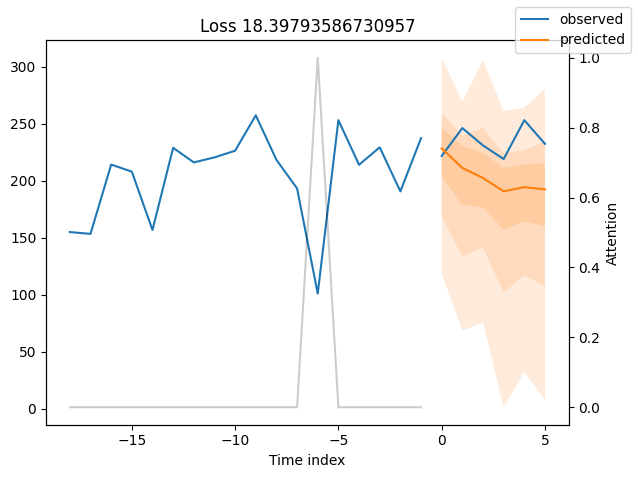

In [ ]:
import matplotlib.pyplot as plt

# Get a batch from the validation dataloader
batch = next(iter(val_dataloader))
x, y_tuple = batch
# Optionally extract the target tensor if needed:
y = y_tuple[0]

# Compute the model's output from x
out = tft(x)

# Now pass x and the model output (not y) to plot_prediction
fig = tft.plot_prediction(x, out, idx=0, add_loss_to_title=True)
plt.show()


In [ ]:
# load the best model according to the validation loss
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
MAE()(predictions.output, predictions.y)

tensor(39.9927)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)

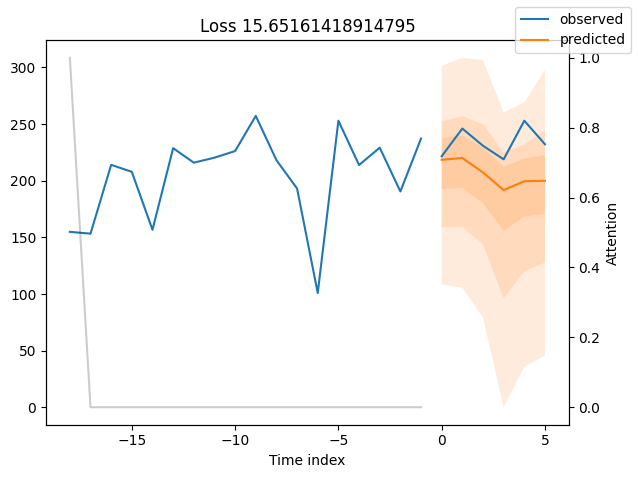

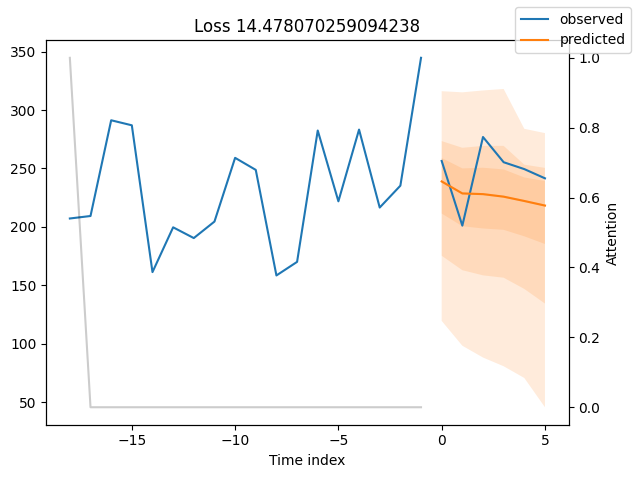

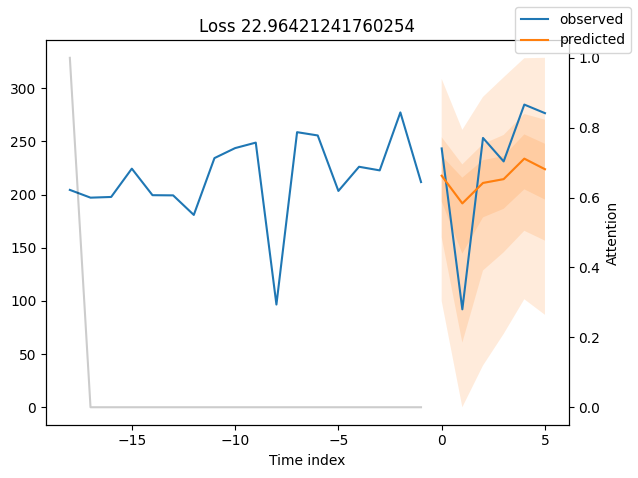

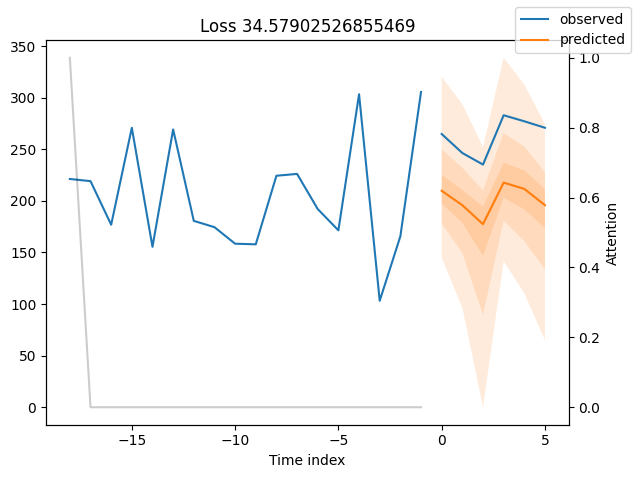

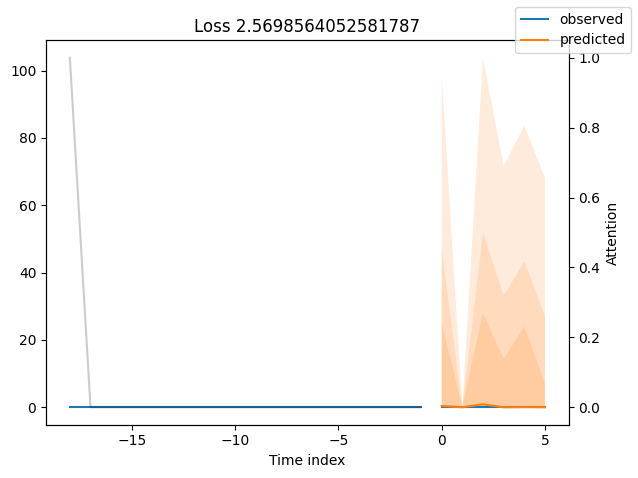

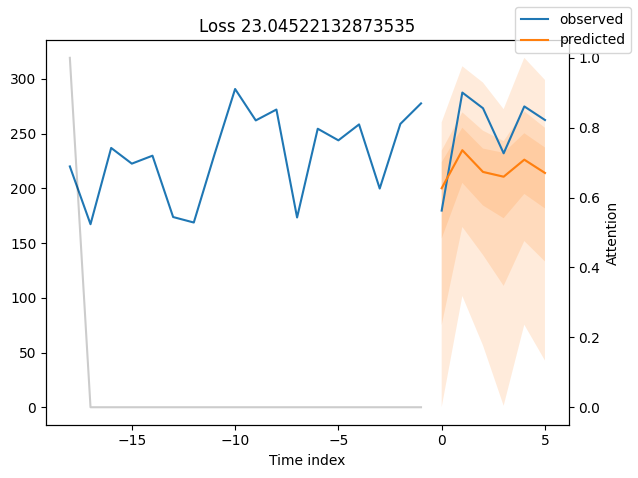

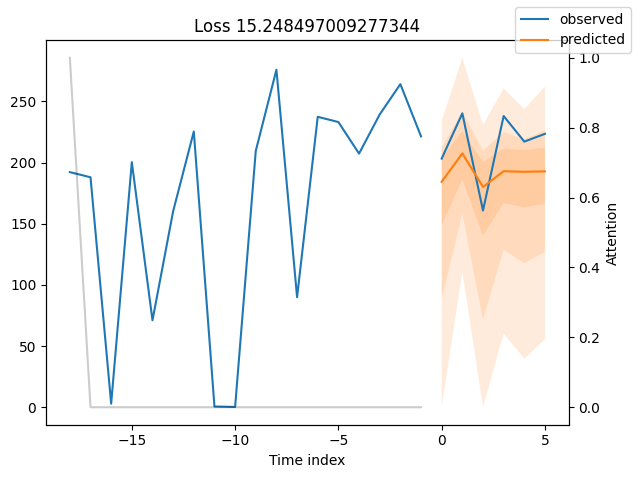

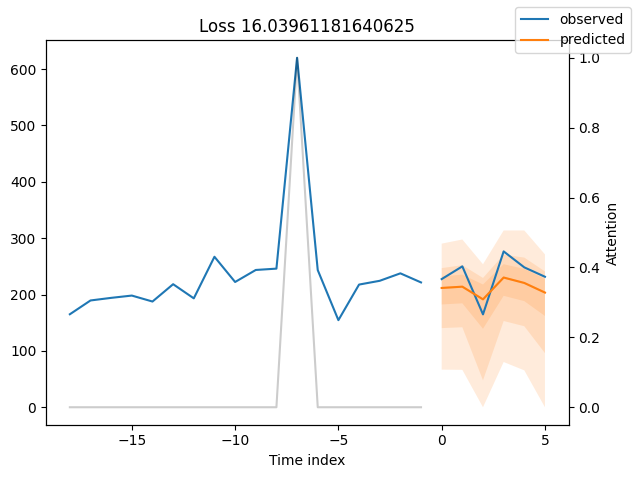

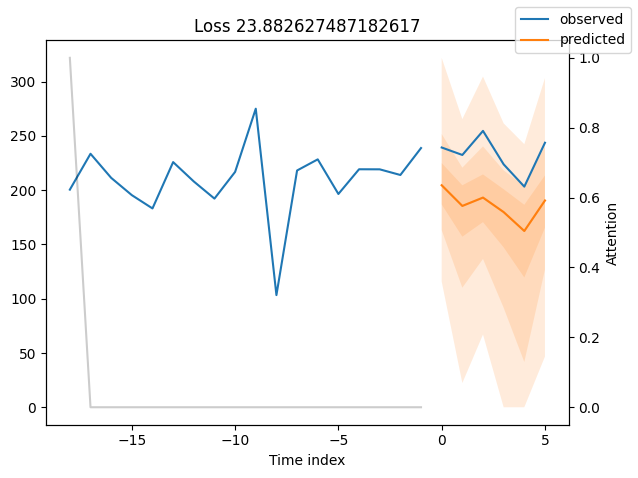

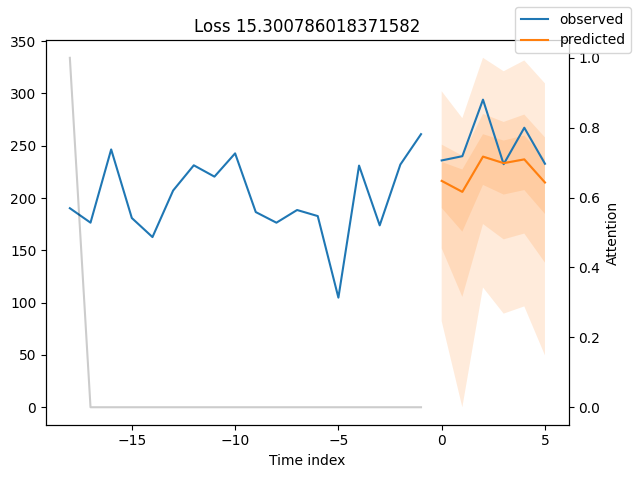

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )

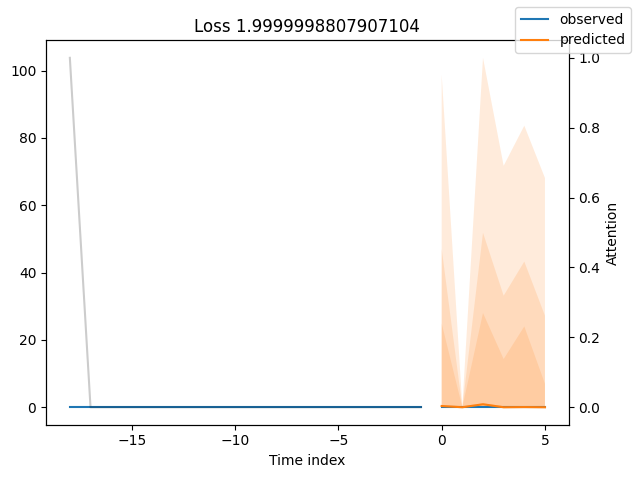

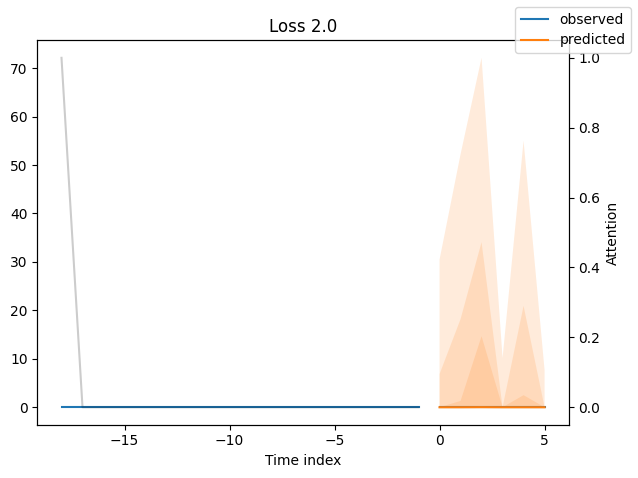

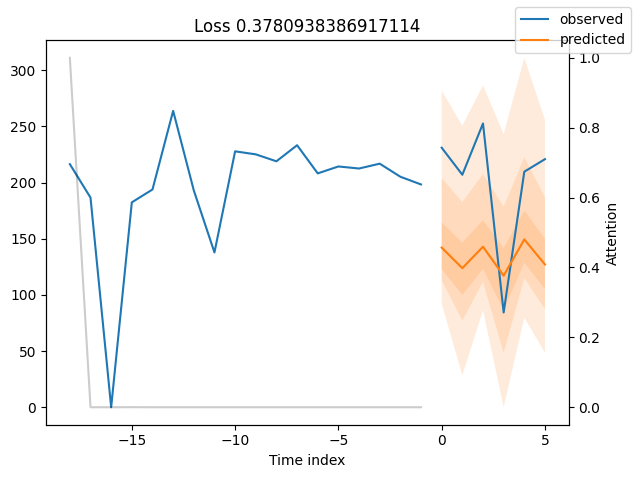

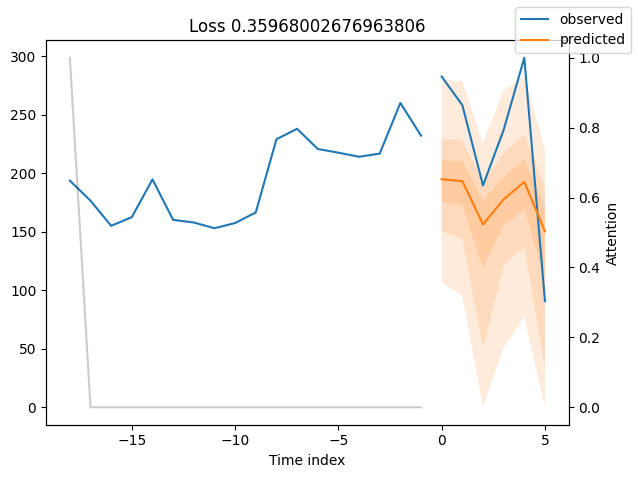

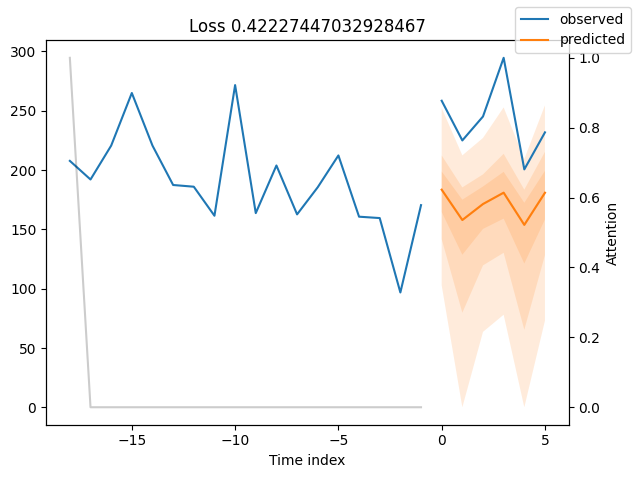

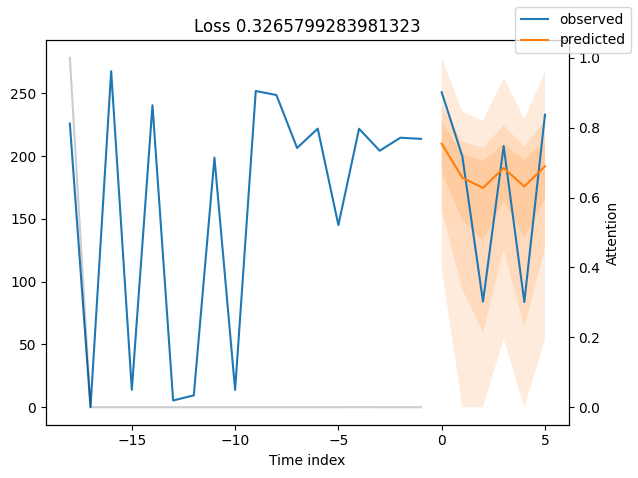

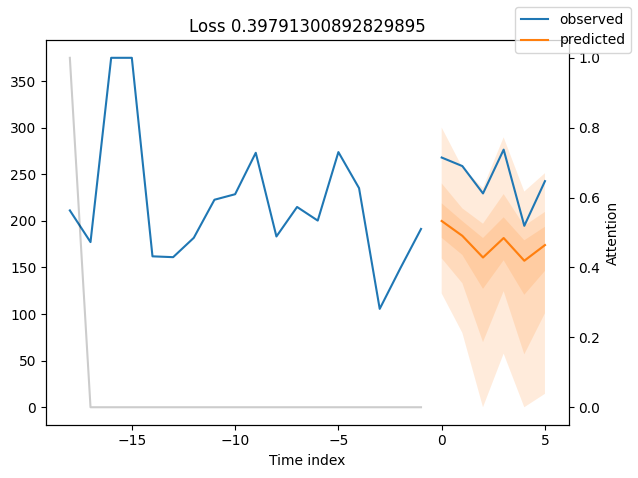

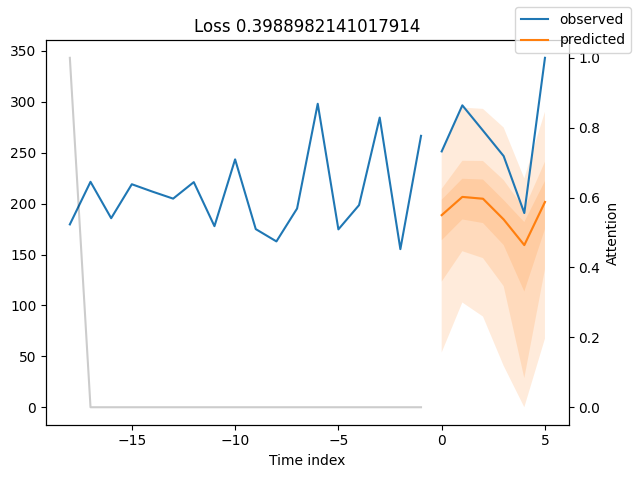

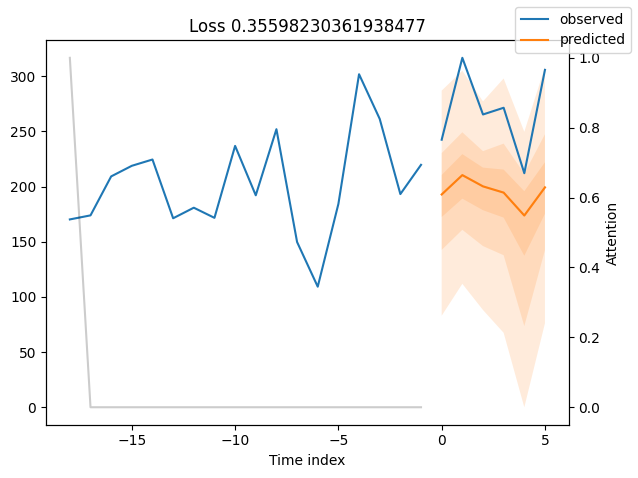

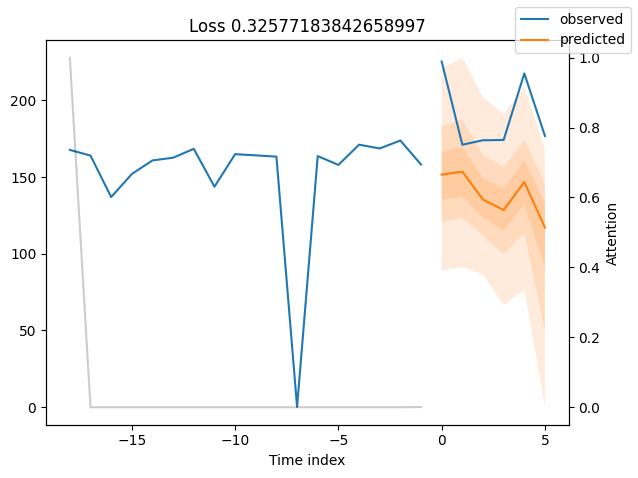

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
mean_losses = SMAPE(reduction="none").loss(predictions.output, predictions.y[0]).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'DollarsPerMegawattHour_center': <Figure size 1000x500 with 2 Axes>,
 'DollarsPerMegawattHour_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'TradingPeriod': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'DollarsPerMegawattHour': <Figure size 1000x500 with 2 Axes>,
 'log_price': <Figure size 1000x500 with 2 Axes>,
 'avg_price_by_point': <Figure size 1000x500 with 2 Axes>,
 'Island': <Figure size 640x480 with 2 Axes>}

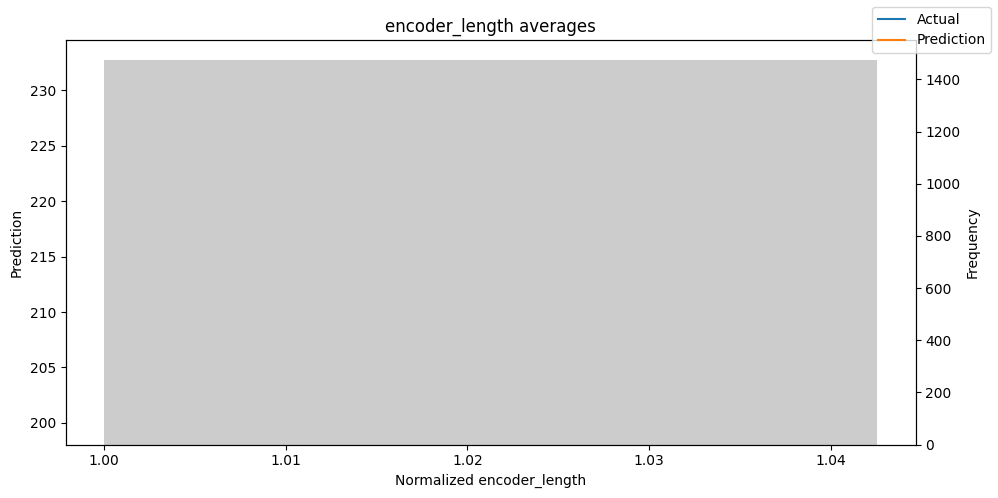

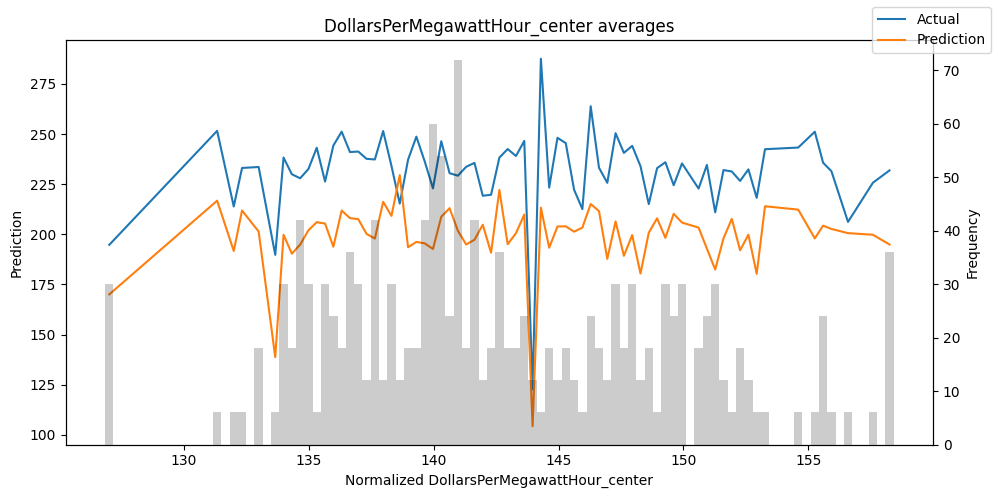

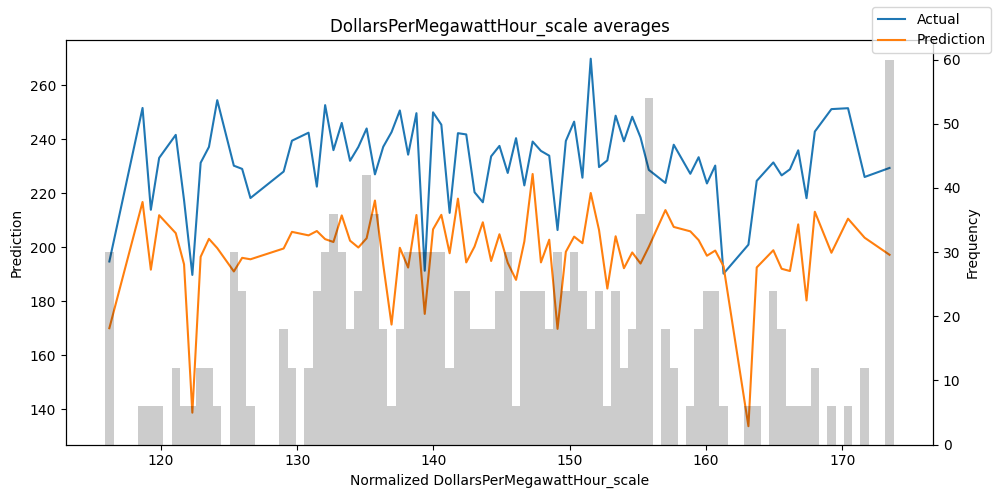

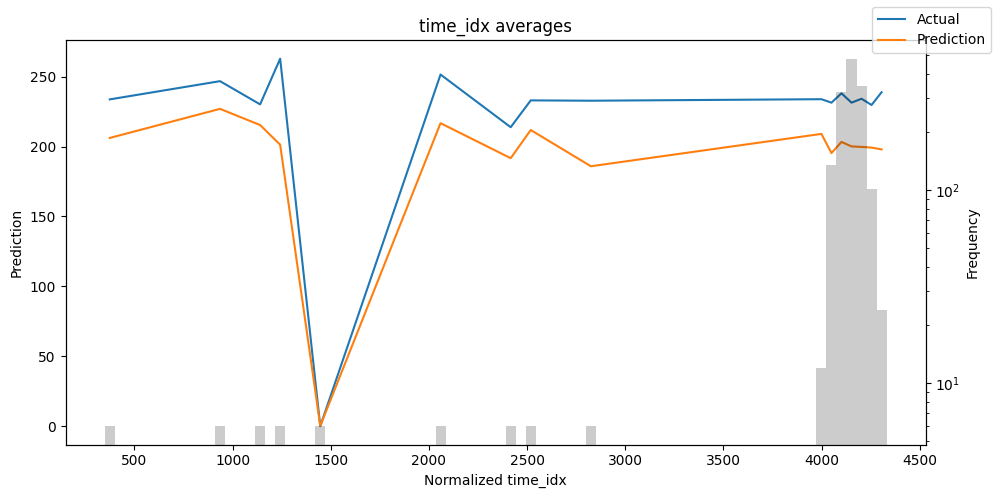

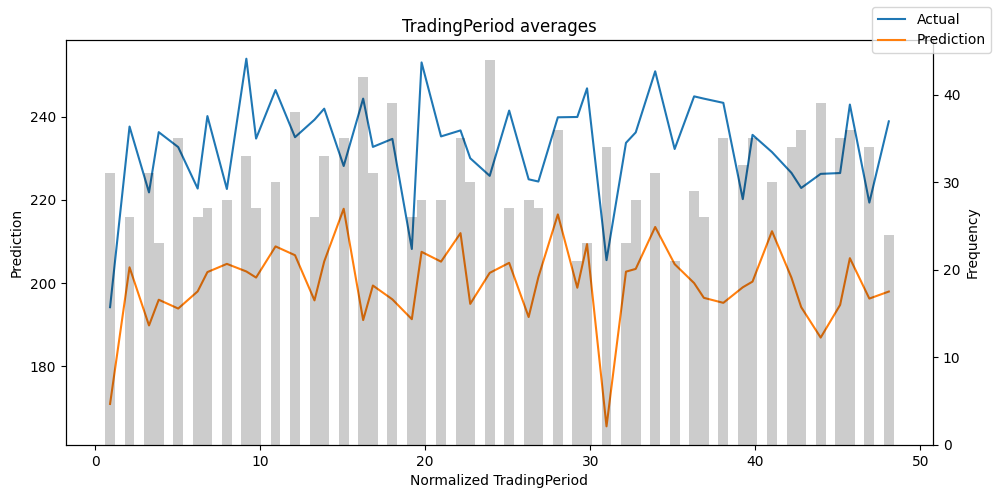

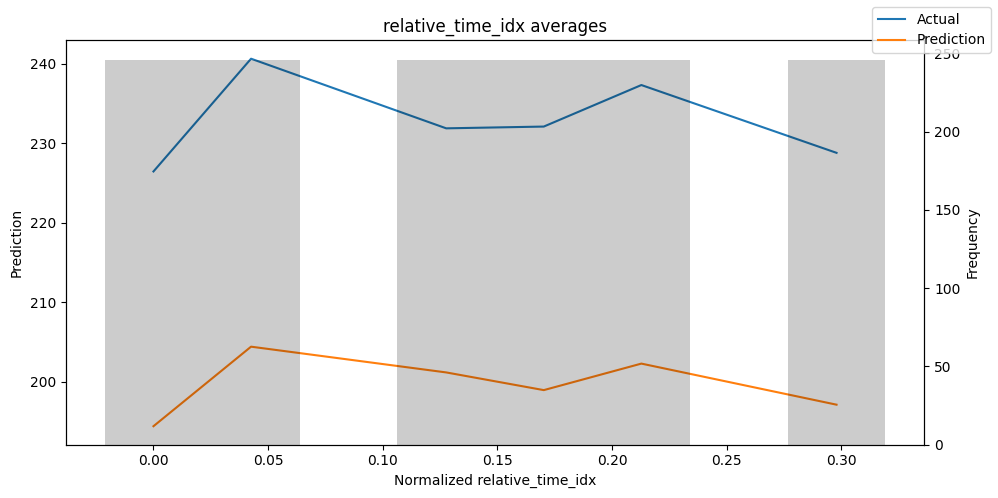

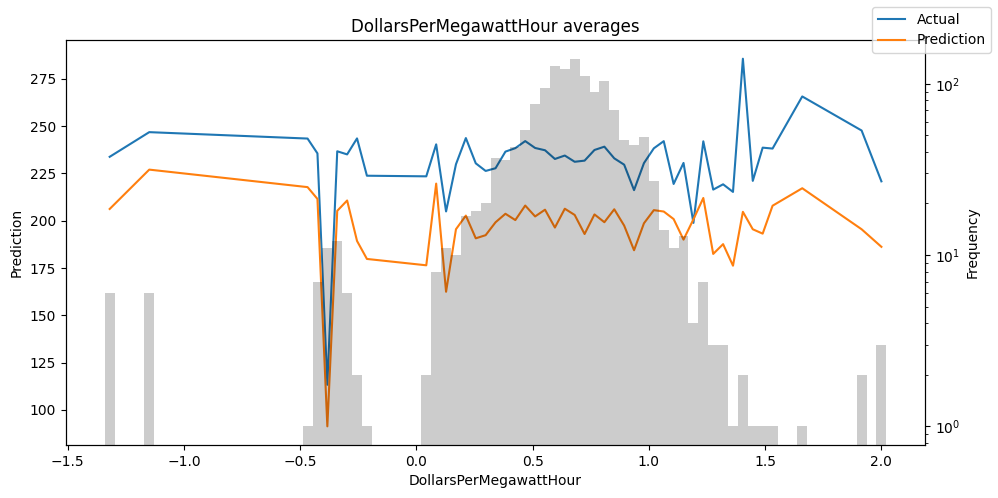

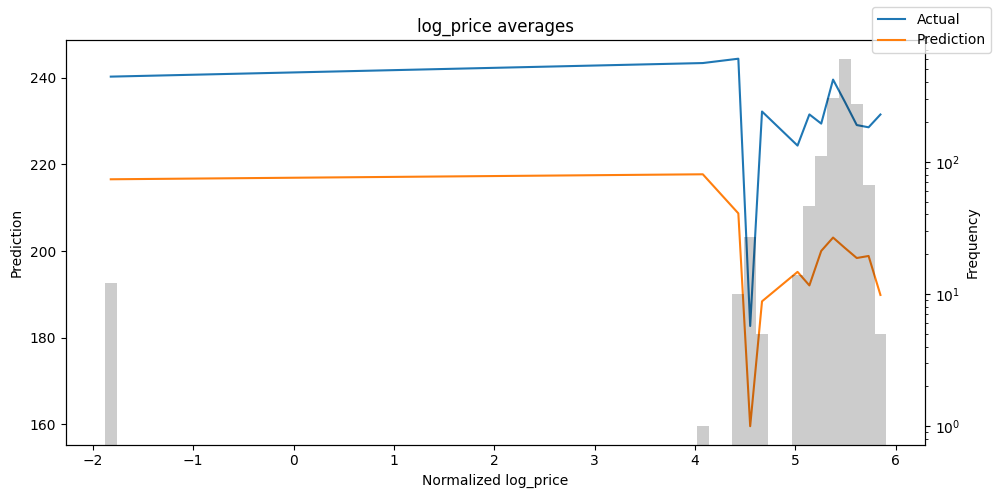

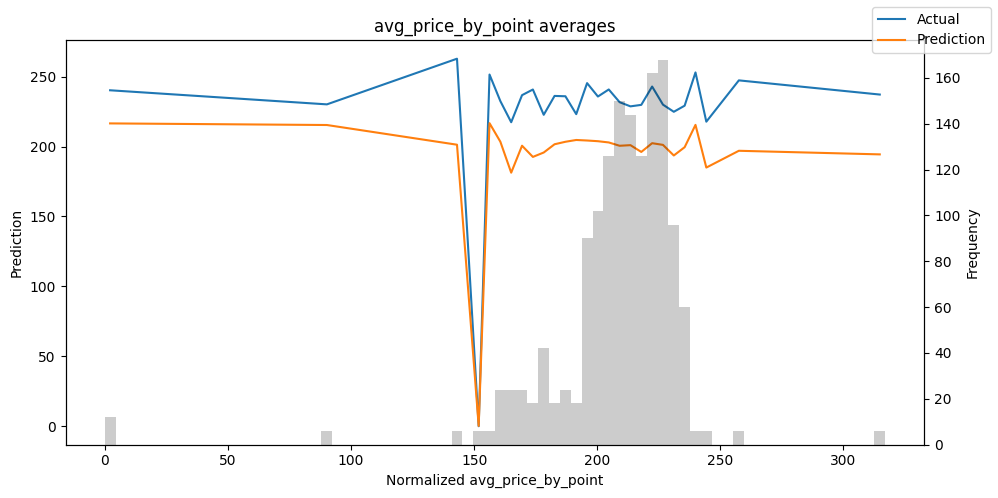

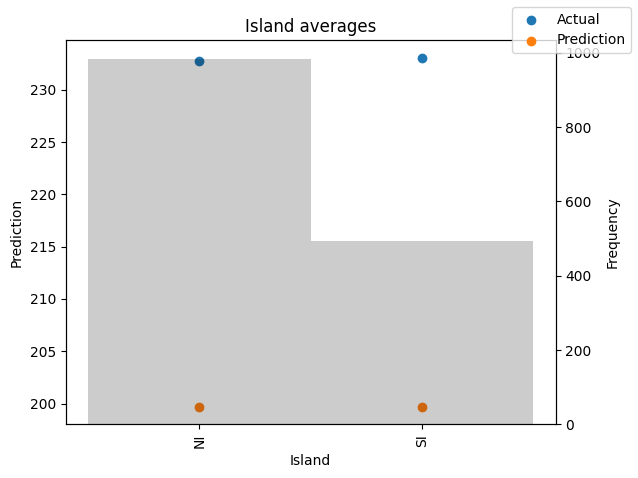

In [ ]:
predictions = best_tft.predict(
    val_dataloader, return_x=True, trainer_kwargs=dict(accelerator="cpu")
)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(
    predictions.x, predictions.output
)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
best_tft.predict(
    training.filter(
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        & (x.time_idx_first_prediction == 15)
    ),
    mode="quantiles",
    trainer_kwargs=dict(accelerator="cpu"),
)


AttributeError: 'DataFrame' object has no attribute 'agency'

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x350 with 1 Axes>,
 'decoder_variables': <Figure size 700x275 with 1 Axes>}

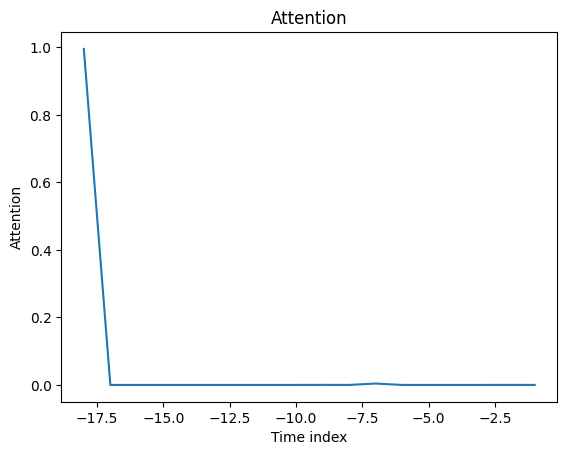

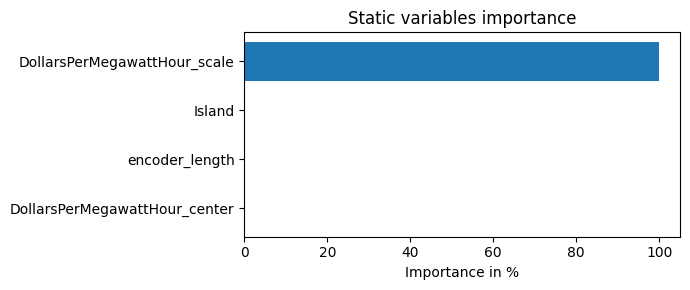

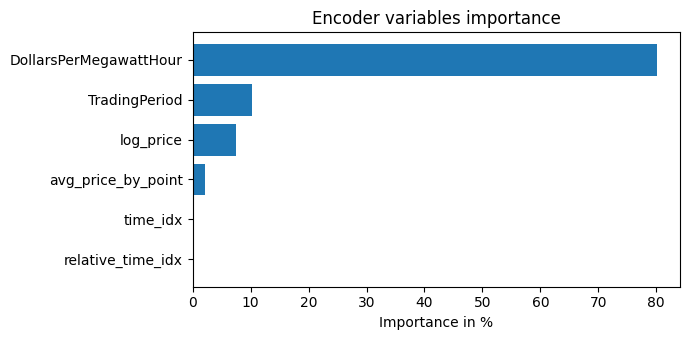

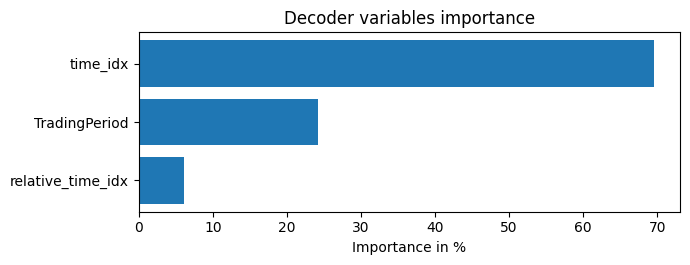

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
import torch
torch.save(tft.state_dict(), "/content/drive/MyDrive/WattGrid/tft_model_1M.pth")
print("Model saved as tft_model.pth")

Model saved as tft_model.pth


In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet, QuantileLoss
import pandas as pd
import numpy as np

# Verify GPU availability
print("CUDA available:", torch.cuda.is_available())
print("GPU Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU Device: NVIDIA L4
